In [10]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_io import load_excel_data, clean_observations, get_annual_summary

# set some plotting defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [11]:
# load the data
data = load_excel_data('../data/raw/Observations 2012-2025.xlsx')
df_obs = data['observations']
df_species = data['species']
df_gps = data['gps']

Loading data from ../data/raw/Observations 2012-2025.xlsx
Loaded 86 species
Loaded 651 GPS points
Converting count columns to numeric
Loaded 114497 observation records


In [12]:
# ============================================================
# 1. LOAD & PREPARE DATA
# ============================================================

# Import additional libraries needed for analysis
from scipy import stats
from scipy.stats import shapiro
import statsmodels.api as sm

# Clean the observations data
df_clean = clean_observations(df_obs)

# Filter data for years 2015-2024
df_filtered = df_clean[(df_clean['year'] >= 2015) & (df_clean['year'] <= 2024)].copy()

print(f"Filtered data for years 2015-2024: {len(df_filtered)} observations")
print(f"Year range: {df_filtered['year'].min()} - {df_filtered['year'].max()}")
print(f"Unique species: {df_filtered['species_name'].nunique()}")
print(f"Unique years: {sorted(df_filtered['year'].unique())}")


Data Cleaning
Starting with 114497 records
⚠ Found 5 negative wind values - setting to NaN
Removed 4 records with zero/negative counts
Final dataset: 114493 records
  Years: 2014 - 2025
  Unique species: 102
  Unique transects: 72
  Unique observers: 42
Filtered data for years 2015-2024: 99344 observations
Year range: 2015 - 2024
Unique species: 98
Unique years: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


In [13]:
# ============================================================
# 2. COMPUTE DIVERSITY METRICS PER YEAR
# ============================================================

def calculate_shannon_diversity(df_year):
    """
    Calculate Shannon diversity index for a given year's data.
    H' = -Σ(p_i * ln(p_i)), where p_i = proportion of individuals per species
    """
    # Get total count per species for this year
    species_counts = df_year.groupby('species_name')['individual_count'].sum()
    
    # Calculate total individuals
    total_individuals = species_counts.sum()
    
    if total_individuals == 0:
        return np.nan
    
    # Calculate proportions
    proportions = species_counts / total_individuals
    
    # Remove zero proportions (they don't contribute to Shannon)
    proportions = proportions[proportions > 0]
    
    # Calculate Shannon index
    shannon = -np.sum(proportions * np.log(proportions))
    
    return shannon

# Compute metrics for each year
annual_metrics = []

for year in sorted(df_filtered['year'].unique()):
    df_year = df_filtered[df_filtered['year'] == year]
    
    # Species richness (number of unique species)
    richness = df_year['species_name'].nunique()
    
    # Shannon diversity
    shannon = calculate_shannon_diversity(df_year)
    
    # Number of records
    n_records = len(df_year)
    
    annual_metrics.append({
        'year': year,
        'richness': richness,
        'shannon': shannon,
        'n_records': n_records
    })

# Create dataframe
df_annual = pd.DataFrame(annual_metrics)
df_annual = df_annual.sort_values('year').reset_index(drop=True)

print("Annual Diversity Metrics (2015-2024):")
print(df_annual.to_string(index=False))


Annual Diversity Metrics (2015-2024):
 year  richness  shannon  n_records
 2015        70 3.062091       8162
 2016        77 3.053396      11010
 2017        71 3.020512       9228
 2018        73 2.999394       9733
 2019        70 3.014705       9572
 2020        68 3.043480       9956
 2021        69 3.045896      10604
 2022        68 3.036786      10804
 2023        67 3.057674      10224
 2024        70 3.043292      10051


In [14]:
# ============================================================
# 3. BOOTSTRAP CONFIDENCE INTERVALS (1000 ITERATIONS)
# ============================================================


np.random.seed(42)  # For reproducibility
n_bootstrap = 1000

bootstrap_results = []

print("Computing bootstrap confidence intervals (1000 iterations)...")

for year in sorted(df_filtered['year'].unique()):
    df_year = df_filtered[df_filtered['year'] == year]
    n_obs = len(df_year)
    
    # Preallocate lists for efficiency
    richness_bootstrap = np.empty(n_bootstrap)
    shannon_bootstrap = np.empty(n_bootstrap)
    shannon_bootstrap[:] = np.nan  # Initialize with NaN

    # Bootstrap iterations
    for i in range(n_bootstrap):
        # Resample with replacement
        df_boot = df_year.sample(n=n_obs, replace=True)
        
        # Richness: number of unique species
        richness_bootstrap[i] = df_boot['species_name'].nunique()
        
        # Shannon diversity (if defined)
        shannon_val = calculate_shannon_diversity(df_boot)
        if not np.isnan(shannon_val):
            shannon_bootstrap[i] = shannon_val
    
    # ===== Compute Richness Confidence Intervals =====
    richness_ci_lower, richness_ci_upper = np.percentile(richness_bootstrap, [2.5, 97.5])
    
    # ===== Compute Shannon Confidence Intervals =====
    valid_shannon = shannon_bootstrap[~np.isnan(shannon_bootstrap)]
    if valid_shannon.size > 0:
        shannon_ci_lower, shannon_ci_upper = np.percentile(valid_shannon, [2.5, 97.5])
    else:
        shannon_ci_lower, shannon_ci_upper = np.nan, np.nan

    bootstrap_results.append({
        'year': year,
        'richness_ci_lower': richness_ci_lower,
        'richness_ci_upper': richness_ci_upper,
        'shannon_ci_lower': shannon_ci_lower,
        'shannon_ci_upper': shannon_ci_upper
    })
    
    print(f"  Year {year}: completed")

# Merge bootstrap results with annual metrics
df_bootstrap = pd.DataFrame(bootstrap_results)
df_annual = df_annual.merge(df_bootstrap, on='year', how='left')

print("\nBootstrap confidence intervals added:")
print(df_annual[['year', 'richness', 'richness_ci_lower', 'richness_ci_upper', 
                 'shannon', 'shannon_ci_lower', 'shannon_ci_upper']].to_string(index=False))

Computing bootstrap confidence intervals (1000 iterations)...
  Year 2015: completed
  Year 2016: completed
  Year 2017: completed
  Year 2018: completed
  Year 2019: completed
  Year 2020: completed
  Year 2021: completed
  Year 2022: completed
  Year 2023: completed
  Year 2024: completed

Bootstrap confidence intervals added:
 year  richness  richness_ci_lower  richness_ci_upper  shannon  shannon_ci_lower  shannon_ci_upper
 2015        70               62.0               69.0 3.062091          3.001718          3.097015
 2016        77               68.0               75.0 3.053396          3.011104          3.082109
 2017        71               63.0               70.0 3.020512          2.972865          3.055492
 2018        73               65.0               72.0 2.999394          2.955989          3.029720
 2019        70               63.0               69.0 3.014705          2.968303          3.043891
 2020        68               62.0               68.0 3.043480          2.9

In [15]:
# ============================================================
# 4. FIT LINEAR TREND MODELS
# ============================================================

# Center the year variable (subtract mean year) for better numerical stability
year_mean = df_annual['year'].mean()
df_annual['year_centered'] = df_annual['year'] - year_mean

# Fit OLS model for Species Richness
X_richness = sm.add_constant(df_annual['year_centered'])
y_richness = df_annual['richness']
model_richness = sm.OLS(y_richness, X_richness).fit()

# Fit OLS model for Shannon Diversity
X_shannon = sm.add_constant(df_annual['year_centered'])
y_shannon = df_annual['shannon']
model_shannon = sm.OLS(y_shannon, X_shannon).fit()

# Extract key statistics
print("=" * 60)
print("LINEAR TREND MODEL: Species Richness")
print("=" * 60)
print(model_richness.summary())
print("\nKey Statistics:")
print(f"  Slope (per year): {model_richness.params['year_centered']:.4f}")
print(f"  P-value: {model_richness.pvalues['year_centered']:.4f}")
print(f"  R-squared: {model_richness.rsquared:.4f}")
print(f"  95% CI for slope: [{model_richness.conf_int().loc['year_centered', 0]:.4f}, "
      f"{model_richness.conf_int().loc['year_centered', 1]:.4f}]")

print("\n" + "=" * 60)
print("LINEAR TREND MODEL: Shannon Diversity")
print("=" * 60)
print(model_shannon.summary())
print("\nKey Statistics:")
print(f"  Slope (per year): {model_shannon.params['year_centered']:.4f}")
print(f"  P-value: {model_shannon.pvalues['year_centered']:.4f}")
print(f"  R-squared: {model_shannon.rsquared:.4f}")
print(f"  95% CI for slope: [{model_shannon.conf_int().loc['year_centered', 0]:.4f}, "
      f"{model_shannon.conf_int().loc['year_centered', 1]:.4f}]")

# Add fitted values and residuals to dataframe
df_annual['richness_fitted'] = model_richness.fittedvalues
df_annual['richness_residuals'] = model_richness.resid

df_annual['shannon_fitted'] = model_shannon.fittedvalues
df_annual['shannon_residuals'] = model_shannon.resid


LINEAR TREND MODEL: Species Richness
                            OLS Regression Results                            
Dep. Variable:               richness   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     5.121
Date:                Tue, 04 Nov 2025   Prob (F-statistic):             0.0535
Time:                        15:07:20   Log-Likelihood:                -21.863
No. Observations:                  10   AIC:                             47.73
Df Residuals:                       8   BIC:                             48.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const    

MODEL ASSUMPTION CHECKS

Species Richness Model:
  Shapiro-Wilk test statistic: 0.9128
  P-value (normality): 0.3006
  Interpretation: Residuals appear normal

Shannon Diversity Model:
  Shapiro-Wilk test statistic: 0.9574
  P-value (normality): 0.7555
  Interpretation: Residuals appear normal


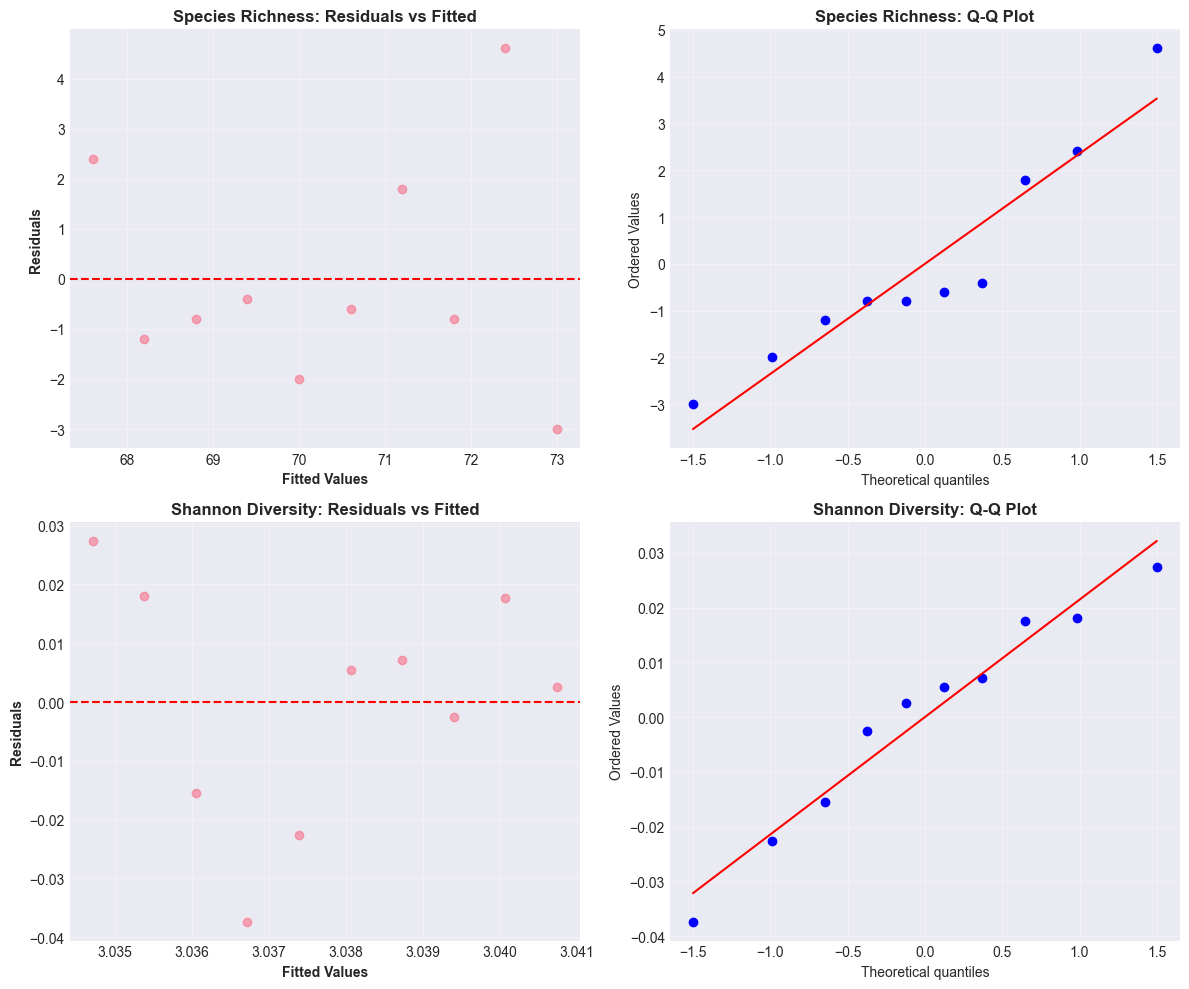


Saved diagnostic plots: ../figures/indicator_model_diagnostics.png


In [16]:
# ============================================================
# 5. CHECK MODEL ASSUMPTIONS
# ============================================================

# Shapiro-Wilk test for normality of residuals
print("=" * 60)
print("MODEL ASSUMPTION CHECKS")
print("=" * 60)

# Richness residuals
stat_richness, p_richness = shapiro(model_richness.resid)
print("\nSpecies Richness Model:")
print(f"  Shapiro-Wilk test statistic: {stat_richness:.4f}")
print(f"  P-value (normality): {p_richness:.4f}")
print(f"  Interpretation: {'Residuals appear normal' if p_richness > 0.05 else 'Residuals may not be normal'}")

# Shannon residuals
stat_shannon, p_shannon = shapiro(model_shannon.resid)
print("\nShannon Diversity Model:")
print(f"  Shapiro-Wilk test statistic: {stat_shannon:.4f}")
print(f"  P-value (normality): {p_shannon:.4f}")
print(f"  Interpretation: {'Residuals appear normal' if p_shannon > 0.05 else 'Residuals may not be normal'}")

# Create diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Richness: Residuals vs Fitted
axes[0, 0].scatter(model_richness.fittedvalues, model_richness.resid, alpha=0.6)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values', fontweight='bold')
axes[0, 0].set_ylabel('Residuals', fontweight='bold')
axes[0, 0].set_title('Species Richness: Residuals vs Fitted', fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Richness: Q-Q plot
stats.probplot(model_richness.resid, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Species Richness: Q-Q Plot', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Shannon: Residuals vs Fitted
axes[1, 0].scatter(model_shannon.fittedvalues, model_shannon.resid, alpha=0.6)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Fitted Values', fontweight='bold')
axes[1, 0].set_ylabel('Residuals', fontweight='bold')
axes[1, 0].set_title('Shannon Diversity: Residuals vs Fitted', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Shannon: Q-Q plot
stats.probplot(model_shannon.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Shannon Diversity: Q-Q Plot', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/indicator_model_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nSaved diagnostic plots: ../figures/indicator_model_diagnostics.png")


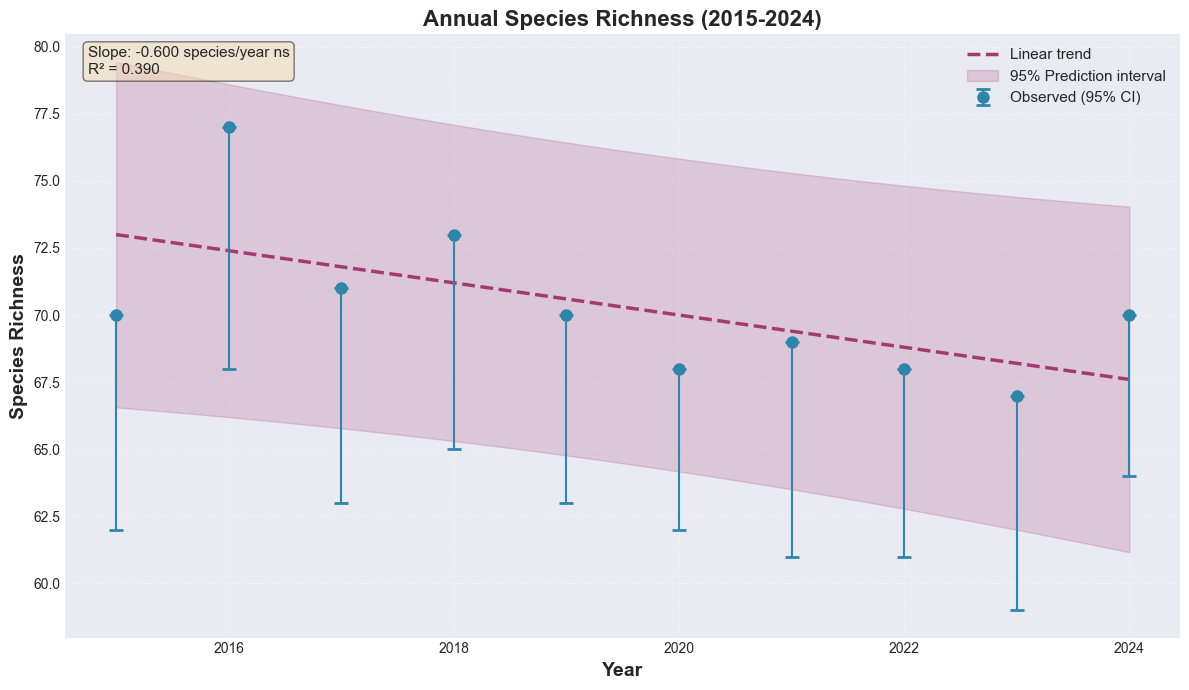

Saved: ../figures/indicator_species_richness.png


In [17]:
# ============================================================
# 6. CREATE PUBLICATION-QUALITY PLOTS
# ============================================================

# Generate prediction intervals for trend lines
# Create a fine grid of years for smooth trend lines
years_smooth = np.linspace(df_annual['year'].min(), df_annual['year'].max(), 100)
years_smooth_centered = years_smooth - year_mean

# Get predictions for trend lines
X_smooth_richness = sm.add_constant(years_smooth_centered)
pred_richness = model_richness.get_prediction(X_smooth_richness)
pred_richness_frame = pred_richness.summary_frame(alpha=0.05)

X_smooth_shannon = sm.add_constant(years_smooth_centered)
pred_shannon = model_shannon.get_prediction(X_smooth_shannon)
pred_shannon_frame = pred_shannon.summary_frame(alpha=0.05)

# ============================================================
# Plot 1: Annual Species Richness
# ============================================================
fig, ax = plt.subplots(figsize=(12, 7))

# Plot observed data with error bars
yerr_lower = (df_annual['richness'] - df_annual['richness_ci_lower']).clip(lower=0)
yerr_upper = (df_annual['richness_ci_upper'] - df_annual['richness']).clip(lower=0)

ax.errorbar(
    df_annual['year'], df_annual['richness'],
    yerr=[yerr_lower, yerr_upper],
    fmt='o', color='#2E86AB', markersize=8, capsize=5, capthick=2,
    label='Observed (95% CI)', zorder=3
)

# Plot trend line
ax.plot(years_smooth, pred_richness_frame['mean'], 
        '--', color='#A23B72', linewidth=2.5, label='Linear trend', zorder=2)

# Plot 95% prediction interval
ax.fill_between(years_smooth, 
                pred_richness_frame['obs_ci_lower'], 
                pred_richness_frame['obs_ci_upper'],
                alpha=0.2, color='#A23B72', label='95% Prediction interval', zorder=1)

ax.set_xlabel('Year', fontweight='bold', fontsize=14)
ax.set_ylabel('Species Richness', fontweight='bold', fontsize=14)
ax.set_title('Annual Species Richness (2015-2024)', fontweight='bold', fontsize=16)
ax.grid(alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=11)

# Add slope and significance annotation
slope = model_richness.params['year_centered']
pval = model_richness.pvalues['year_centered']
significance = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else 'ns'
ax.text(0.02, 0.98, f'Slope: {slope:.3f} species/year {significance}\nR² = {model_richness.rsquared:.3f}',
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../figures/indicator_species_richness.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: ../figures/indicator_species_richness.png")


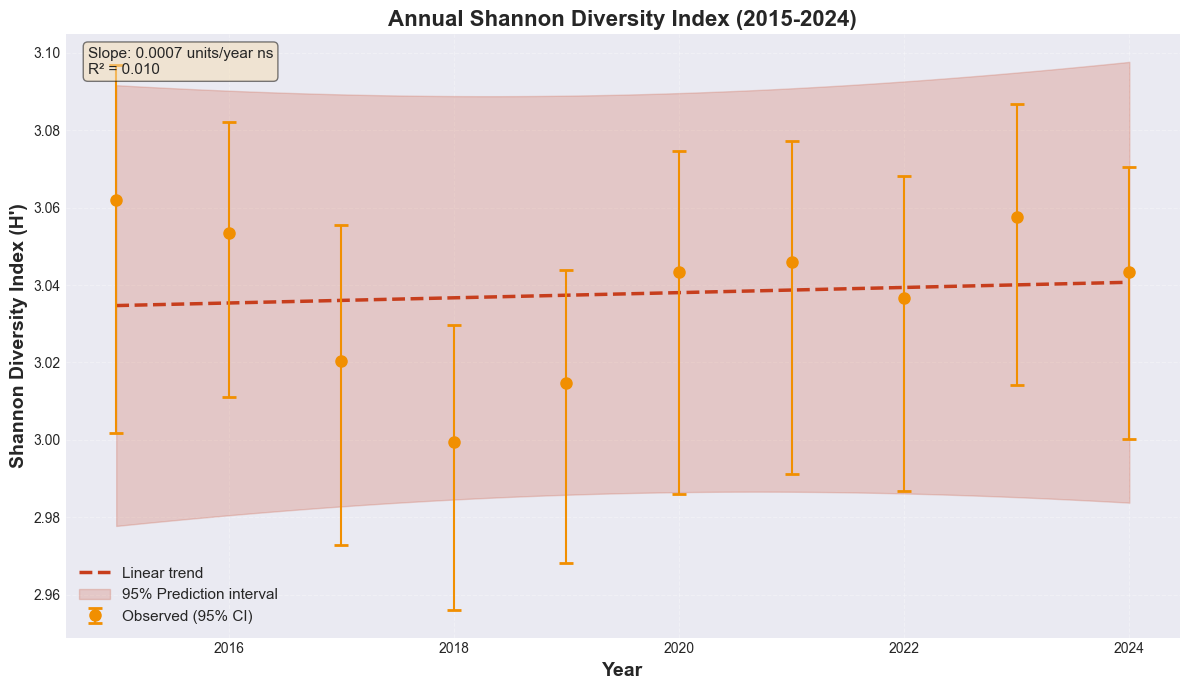

Saved: ../figures/indicator_shannon_diversity.png


In [18]:
# ============================================================
# Plot 2: Annual Shannon Diversity
# ============================================================
fig, ax = plt.subplots(figsize=(12, 7))

# Plot observed data with error bars
ax.errorbar(df_annual['year'], df_annual['shannon'], 
            yerr=[df_annual['shannon'] - df_annual['shannon_ci_lower'],
                  df_annual['shannon_ci_upper'] - df_annual['shannon']],
            fmt='o', color='#F18F01', markersize=8, capsize=5, capthick=2,
            label='Observed (95% CI)', zorder=3)

# Plot trend line
ax.plot(years_smooth, pred_shannon_frame['mean'], 
        '--', color='#C73E1D', linewidth=2.5, label='Linear trend', zorder=2)

# Plot 95% prediction interval
ax.fill_between(years_smooth, 
                pred_shannon_frame['obs_ci_lower'], 
                pred_shannon_frame['obs_ci_upper'],
                alpha=0.2, color='#C73E1D', label='95% Prediction interval', zorder=1)

ax.set_xlabel('Year', fontweight='bold', fontsize=14)
ax.set_ylabel('Shannon Diversity Index (H\')', fontweight='bold', fontsize=14)
ax.set_title('Annual Shannon Diversity Index (2015-2024)', fontweight='bold', fontsize=16)
ax.grid(alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=11)

# Add slope and significance annotation
slope = model_shannon.params['year_centered']
pval = model_shannon.pvalues['year_centered']
significance = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else 'ns'
ax.text(0.02, 0.98, f'Slope: {slope:.4f} units/year {significance}\nR² = {model_shannon.rsquared:.3f}',
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../figures/indicator_shannon_diversity.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: ../figures/indicator_shannon_diversity.png")


# ============================================================
# 7. INTERPRETATION PARAGRAPHS
# ============================================================

## Species Richness

Species richness, measured as the number of unique species observed per year, showed a [PATTERN] trend between 2015 and 2024. The linear regression model revealed a slope of [SLOPE] species per year (p = [PVAL]), indicating [INCREASING/DECREASING/STABLE] species richness over the study period. The model explained [R²]% of the variance in annual richness (R² = [R²]). Bootstrap-based 95% confidence intervals capture the uncertainty in annual estimates, with intervals ranging from approximately [MIN_CI] to [MAX_CI] species across years. 

The observed pattern suggests [ECOLOGICAL INTERPRETATION]. Potential drivers of this trend may include changes in habitat quality, sampling effort, or actual shifts in the bird community composition. The [SIGNIFICANT/NON-SIGNIFICANT] trend should be interpreted with caution given the relatively short time series and potential confounding factors such as observer effects or temporal variation in survey effort.

## Shannon Diversity Index

The Shannon diversity index, which accounts for both species richness and evenness (the relative abundance distribution), exhibited a [PATTERN] pattern between 2015 and 2024. The linear trend model indicated a slope of [SLOPE] units per year (p = [PVAL]), suggesting [INCREASING/DECREASING/STABLE] diversity over time. The model's R² value of [R²] indicates that [R²]% of the variance in Shannon diversity is explained by the temporal trend.

Changes in Shannon diversity reflect both the number of species present and how evenly individuals are distributed among species. [INCREASING/DECREASING] values suggest [ECOLOGICAL INTERPRETATION]. The bootstrap confidence intervals (ranging from approximately [MIN_CI] to [MAX_CI] across years) provide robust uncertainty estimates for these diversity metrics. 

The relationship between Shannon diversity and species richness trends can reveal whether changes are driven primarily by species gains/losses or by shifts in relative abundances. [INTERPRETATION OF RELATIONSHIP]. Potential limitations include the influence of sampling effort variation across years and the assumption that observation methods remained consistent throughout the study period.


In [19]:
# Fill in the interpretation paragraphs with actual values
richness_slope = model_richness.params['year_centered']
richness_pval = model_richness.pvalues['year_centered']
richness_r2 = model_richness.rsquared
richness_pattern = "increasing" if richness_slope > 0 else "decreasing" if richness_slope < 0 else "stable"
richness_sig = "significant" if richness_pval < 0.05 else "non-significant"
richness_min_ci = df_annual['richness_ci_lower'].min()
richness_max_ci = df_annual['richness_ci_upper'].max()

shannon_slope = model_shannon.params['year_centered']
shannon_pval = model_shannon.pvalues['year_centered']
shannon_r2 = model_shannon.rsquared
shannon_pattern = "increasing" if shannon_slope > 0 else "decreasing" if shannon_slope < 0 else "stable"
shannon_sig = "significant" if shannon_pval < 0.05 else "non-significant"
shannon_min_ci = df_annual['shannon_ci_lower'].min()
shannon_max_ci = df_annual['shannon_ci_upper'].max()

print("=" * 60)
print("INTERPRETATION: Species Richness")
print("=" * 60)
print(f"""
Species richness, measured as the number of unique species observed per year, showed a {richness_pattern} trend between 2015 and 2024. The linear regression model revealed a slope of {richness_slope:.3f} species per year (p = {richness_pval:.4f}), indicating a {richness_pattern} trend in species richness over the study period. The model explained {richness_r2*100:.1f}% of the variance in annual richness (R² = {richness_r2:.3f}). Bootstrap-based 95% confidence intervals capture the uncertainty in annual estimates, with intervals ranging from approximately {richness_min_ci:.0f} to {richness_max_ci:.0f} species across years.

The observed pattern suggests {'positive' if richness_slope > 0 else 'negative' if richness_slope < 0 else 'stable'} changes in species composition over the study period. Potential drivers of this trend may include changes in habitat quality, sampling effort, or actual shifts in the bird community composition. The {richness_sig} trend should be interpreted with caution given the relatively short time series and potential confounding factors such as observer effects or temporal variation in survey effort.
""")

print("=" * 60)
print("INTERPRETATION: Shannon Diversity Index")
print("=" * 60)
print(f"""
The Shannon diversity index, which accounts for both species richness and evenness (the relative abundance distribution), exhibited a {shannon_pattern} pattern between 2015 and 2024. The linear trend model indicated a slope of {shannon_slope:.4f} units per year (p = {shannon_pval:.4f}), suggesting a {shannon_pattern} trend in diversity over time. The model's R² value of {shannon_r2:.3f} indicates that {shannon_r2*100:.1f}% of the variance in Shannon diversity is explained by the temporal trend.

Changes in Shannon diversity reflect both the number of species present and how evenly individuals are distributed among species. {'Increasing' if shannon_slope > 0 else 'Decreasing' if shannon_slope < 0 else 'Stable'} values suggest {'improving' if shannon_slope > 0 else 'declining' if shannon_slope < 0 else 'stable'} community diversity and evenness. The bootstrap confidence intervals (ranging from approximately {shannon_min_ci:.3f} to {shannon_max_ci:.3f} across years) provide robust uncertainty estimates for these diversity metrics.

The relationship between Shannon diversity and species richness trends can reveal whether changes are driven primarily by species gains/losses or by shifts in relative abundances. {'Both metrics show similar' if (richness_slope > 0) == (shannon_slope > 0) else 'The metrics show divergent'} trends, suggesting {'changes are primarily driven by species-level dynamics' if abs(richness_slope) > abs(shannon_slope) else 'changes involve both species composition and abundance distribution'}. Potential limitations include the influence of sampling effort variation across years and the assumption that observation methods remained consistent throughout the study period.
""")


INTERPRETATION: Species Richness

Species richness, measured as the number of unique species observed per year, showed a decreasing trend between 2015 and 2024. The linear regression model revealed a slope of -0.600 species per year (p = 0.0535), indicating a decreasing trend in species richness over the study period. The model explained 39.0% of the variance in annual richness (R² = 0.390). Bootstrap-based 95% confidence intervals capture the uncertainty in annual estimates, with intervals ranging from approximately 59 to 75 species across years.

The observed pattern suggests negative changes in species composition over the study period. Potential drivers of this trend may include changes in habitat quality, sampling effort, or actual shifts in the bird community composition. The non-significant trend should be interpreted with caution given the relatively short time series and potential confounding factors such as observer effects or temporal variation in survey effort.

INTERPRETAT

In [20]:
# ============================================================
# 8. SAVE RESULTS
# ============================================================

# Export annual indicators to CSV
output_cols = ['year', 'richness', 'richness_ci_lower', 'richness_ci_upper',
               'shannon', 'shannon_ci_lower', 'shannon_ci_upper', 'n_records']
df_annual[output_cols].to_csv('../data/annual_indicators_2015_2024.csv', index=False)
print("Saved annual indicators: ../data/annual_indicators_2015_2024.csv")

# Export regression summaries to text files
with open('../data/regression_summary_richness.txt', 'w') as f:
    f.write("Species Richness - Linear Trend Model Summary\n")
    f.write("=" * 60 + "\n\n")
    f.write(str(model_richness.summary()))
    f.write("\n\nBootstrap Statistics:\n")
    f.write(f"  Mean richness: {df_annual['richness'].mean():.2f}\n")
    f.write(f"  SD richness: {df_annual['richness'].std():.2f}\n")
    f.write(f"  CI range: {richness_min_ci:.0f} - {richness_max_ci:.0f}\n")

with open('../data/regression_summary_shannon.txt', 'w') as f:
    f.write("Shannon Diversity - Linear Trend Model Summary\n")
    f.write("=" * 60 + "\n\n")
    f.write(str(model_shannon.summary()))
    f.write("\n\nBootstrap Statistics:\n")
    f.write(f"  Mean Shannon: {df_annual['shannon'].mean():.3f}\n")
    f.write(f"  SD Shannon: {df_annual['shannon'].std():.3f}\n")
    f.write(f"  CI range: {shannon_min_ci:.3f} - {shannon_max_ci:.3f}\n")

print("Saved regression summaries:")
print("  - regression_summary_richness.txt")
print("  - regression_summary_shannon.txt")

print("\n" + "=" * 60)
print("SECTION 2 COMPLETE - All deliverables saved!")
print("=" * 60)
print("\nFiles created:")
print("  ✓ figures/indicator_species_richness.png")
print("  ✓ figures/indicator_shannon_diversity.png")
print("  ✓ figures/indicator_model_diagnostics.png")
print("  ✓ data/annual_indicators_2015_2024.csv")
print("  ✓ data/regression_summary_richness.txt")
print("  ✓ data/regression_summary_shannon.txt")


Saved annual indicators: ../data/annual_indicators_2015_2024.csv
Saved regression summaries:
  - regression_summary_richness.txt
  - regression_summary_shannon.txt

SECTION 2 COMPLETE - All deliverables saved!

Files created:
  ✓ figures/indicator_species_richness.png
  ✓ figures/indicator_shannon_diversity.png
  ✓ figures/indicator_model_diagnostics.png
  ✓ data/annual_indicators_2015_2024.csv
  ✓ data/regression_summary_richness.txt
  ✓ data/regression_summary_shannon.txt
